In [1]:
import pandas as pd 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 

=================================================================================================================
# Lecture Notes: Decision Trees


##### D.Vidotto, Data Mining: JBI030 2019/2020


=================================================================================================================

Decision trees perform binary splits in the features space, and can therefore be represented as [binary trees](https://en.wikipedia.org/wiki/Binary_tree). They provide an highly interpretable Data Mining tool, whose results can be easily communicated. Their downside is that they easily tend to overfit the training dataset, and in general do not always perform great. In this notebook, we will explore both Classification and Regression Trees algorithms. 

Students are assumed to have understood the following concepts during the class: 

* components of a decision tree
* node purity/impurity
* Gini index, entropy index
* the decision tree algorithm
* regression trees 
* tree depth 

In this notebook, we will review the following topics: 

1. Decision Trees: Introduction 
   * examples
   * definitions 
1. Decision Tree Algorithm 
 * Classification Trees
   * Gini index and Entropy
 * choosing the splits 
 * Regression Trees
1. Tree depth and other hyperparameters 
1. Feature Importance 
1. Pathological Cases
1. Other Remarks 
1. Examples in Python 
 * Classification Trees
 * Regression Trees
1. Example on the Heart Dataset 


## 1. Decision Trees: Introduction
### 1.1 Example 1
Suppose we have the following dataset: 

<img src="./img/decision_trees/data_example.png" width="300" height="50"/>

Training a decision tree on this dataset produces the following decision boundaries: 

<img src="./img/decision_trees/tree_boundary.png" width="300" height="50"/>

As we can notice, decision trees seek to find *rectangular regions* (hyper-rectangles in higher dimensions) in the space of the features, such that within each such partition there are as many data points as possible from the same class. Notice that finding rectangular regions really means that the boundaries (i.e., the splits) found by Decision Trees are *axes-aligned*.


From these decision boundaries, we can extrapolate the following *decision rules*: 

```python
|--- if X2 <= 13.55: 
|    |--- if X1 <= 13.13: 
|    |    |--- return Class 3 
|    |--- else: 
|    |    |--- return Class 2
|----|else:
|    |--- return Class 1
```

Try to compare the rules found by the tree with the decision boundaries, and convince yourself that they are conveying the same information! 
<br>
Another, equivalent (and surely most notorius!) way to describe the output of a tree is by using the *tree representation*: 

<br>
<img src="./img/decision_trees/example_tree.png" width="250" height="50"/>
<br>

Before delving into the definitions of the components of a tree, try to interpret the tree by yourself (and compare it with its rules and decision boundaries). 


### 1.2 Decision Tree: Definitions

A decision tree is composed by *nodes*, *branches* and *leaves*: 

* **nodes** are used to denote the splits performed by the tree (or to denote a final prediction) 
* each split involves one feature of the dataset, which is *tested* against a value 
* if the test is true, units will go down one of the two **branches** (=edges) of the node; if it is false, units will go down the other branch 
* the **root** node is the top-most node, where the first split occurs 
* the **internal nodes** (a.k.a. decision nodes) are all the other nodes present at lower *levels* of the tree
* the **leaves** (a.k.a. terminal nodes) are nodes at the last level of the tree; they represent the *prediction* made by the tree, given the values tested at higher levels (for Classification trees, leaves predict a class or the class probabilities; for Regression trees, leaves predict a number)
* **children** nodes are the nodes generated when splitting a node; the corresponding node that generates the split is called  **parent** node  
* the length of the longest path from the root to a leaf is called the **depth** of the tree
* the number of nodes in the tree is called **size** of the tree

<br>
<img src="./img/decision_trees/tree_def.png" width="450" height="50"/>
<br>

Depending on the nature of the feature chosen for the split, we can encounter two types of test inside each node: 
* if the feature is continuous (or discrete), then the test involves a *inequality* (as in the previous example) against a value within the range of that feature
* if the feature is categorical, then the test performed is an *equality* test (as in the example below) against one of the categories of the feature of interest   

Decision trees seek to train the smallest possible tree (i.e., with the lowest possible number of nodes) that classifies correctly as many units as possible (i.e., having most units from the same class within the regions detected by the tree).  

Intepreting a tree is very easy: we just need to consider the values of the features present in the nodes, and understand to what leaf node they lead. The final prediction is given by the *combined interaction* of the features present at each level of the tree. For example, in the example above, when $X_2$ takes on a values smaller than 13.55, and $X_1$ a value smaller than 13.13, then we fall into the region of Class 3. 

We will see that datasets involving a larger number of predictors that trees may not (and indeed they often do not in practice) use the whole set of features in their nodes, but only choose some of them (performing in this way automatic feature selection).  <br>
Performing predictions with a tree is also very easy. Once we know the values of the features for the observation we want to predict, we must test them against the values present in each of the nodes, drop every time the unit down the correct branches, and finally predict the value reported by the corresponding leaf node. 

### 1.3 Example 2 
We now consider the *weather* dataset with 5 features and 1 categorical output measured for $n=6$ different days. The features involve a bunch of metheorological and temporal conditions (i.e., temperature, outlook, humidity level, wind strength, and a dummy indicating whether the corresponding day was in a weekend or not). The class indicates whether the corresponding day we went out to play football, or not. 

The dataset is the following one: 

<br>

|Example| Outlook | Weekend |  Humidity | Wind | Temperature | Played Football?  |  
|:----:|:------:|:-----:|:-----:|:-----:|:-----:|:-----:|
|1| Sunny | Y | Normal | Weak | 24 | Y | 
|2| Sunny | N | Normal | Strong | 18 | Y | 
|3| Sunny | Y | Normal | Strong | 30 | Y | 
|4| Overcast | N | High | Strong| 20 | N | 
|5| Rainy | N | Normal | Weak | 21 | N | 
|6| Sunny | Y| Normal | Strong | 16 | N | 

<br>

Suppose we obtain a tree like this:  

<br>
<img src="./img/decision_trees/football_tree_1.png" width="300" height="50"/>
<br>

Answer the following questions: 
1. Is there any observation miss-classified by the tree? 
1. Can you come up with a better tree? (Remember: *better* in context of decision trees means that there are as fewer miss-classification as possible -possibly 0- with the smallest possible number of nodes)
1. Suppose we have a new observation: $\mathbf{x}^*=[Sunny,\ No,\ High,\ Strong,\ 22]$. How would the tree that you detected in the previous point classify it? Do you need the values of all features in order to perform the prediction?  
1. Write down the tree in form of *rules*

## 2. Decision Tree Algorithm 
To perform training, decision trees follow a procedure known as [divide-and-conquer](https://en.wikipedia.org/wiki/Divide-and-conquer_algorithm): they recursively perform a partition of the data into subsets, which in turn are partitioned into other subsets; the partitioning continues until the algorithm finds the most possible *homogeneous* regions. 

### 2.1 Classification Trees
#### 2.1.1 Measures of Impurity
With classification trees, *homogeneity* of a region is defined in terms of *node purity*. Consider this example: we have $n=10$ units, 5 of them come from Class 0, and other 5 of them come from Class 1. We find two possible ways to perform the partition: 
* Case 1: Region 1 = [0, 0, 0, 1, 1]; Region 2 = [1, 1, 1, 0, 0]
* Case 2: Region 2 = [0, 0, 0, 0 ,1, 0]; Region 2 = [1, 1, 1, 1] 

In the first case, two regions are found that contain five observations each. In region 1, the *majority class* is Class 0 having three units vs. 2 units of the minority class (Class 1). The situation is reversed in region 2, where the majority class is Class 1, also with three unis. In the second case, region 1 contains six observations, while region 2 contains four observations. Region 1 contains 5 units from class 0 and only 1 from class 1, while region 2 has four units all belonging to class 1. In this second case, we see that region 2 is completely *pure*, and region 1 is almost pure. The regions found by the first partition, on the other hand, are more *impure* (less homogeneous). Intuitively, then, we should prefer the second partition, as it leads to purest nodes (which, in turn, means that we can grow a smaller tree, and terminate the algorithm faster). 

Decision trees use indicators that measure node *impurity* to decide how to perform the split. In particular, the two most common impurity measures used by classification trees are the *Gini index* and the *entropy* measure. 

**The Gini Impurity Index**. Suppose we have $C\geq2$ classes, and let's that a region resulting from partition $m$ with $R_m$. There are in total $M$ nodes, so that that the whole, original space of the data is $R=R_1\cup R_2\cdots\cup R_m\cdots\cup R_M$. We can define the probability of observing a unit from class $c \in \{1,...,C\}$ in region $R_m$ with: 

$$ p_{c,m} = \frac{|R_{c,m}|}{|R_m|} = \frac{\#\ of\ units\ in\ region\ R_m\ from\ class\ c}{total\ number\ of\ units\ in\  region\ R_m}$$

The Gini impurity for the $m$-th partition is then defined as: 

$$ G(R_m) = \sum_{c=1}^{C}p_{c,m}(1-p_{c,m})  $$

$G(R_m)$ reaches a minimum of 0 when all units in the region come from the same class (the class distribution is maximually homogeneous), while it reaches a maximum when the classes are evenly distributed in the region (class distribution is maximally heterogeneous). (Check this by yoursefl, for example with the two class case!). This makes the Gini impurity index a suitable indicator for deciding on the splitting of the tree's nodes. 

Let's suppose we need to perform a partition of a region $R_m$, and we are evaluating the Gini index of the split at a point $X_j= x_j$ for feature $X_j$ (how to select such point will be explained shortly). This split will then yield two candidate sub-regions, a 'left' and a 'right' one: 

$$R_L = \{X|X_j\leq x_j\}\ and\ R_R = \{X|X_j > x_j\} \ s.t.\ R_m=R_L\cup R_R$$


<br>
<img src="./img/decision_trees/split_r_l.png" width="200" height="50"/>
<br>

The overall impurtity yielded by this split is: 

$$ Q(R_m) = \frac{|R_L|}{|R_m|}G(R_L) + \frac{|R_R|}{|R_m|}G(R_R) $$

where: 
* $\frac{|R_L|}{|R_m|}$ and $\frac{|R_R|}{|R_m|}$ are the fractions of units from region $m$ that fall into the left and right branch, respectively
* $G(R_L)$ and $G(R_R)$ are the Gini impurities calculated within each of the new sub-regions
* therefore, $Q(R_m)$ is just a weighted average of the Gini indices calculated within each sub-region

As an example, let's calculate the Gini impurities for the two potential splits considered above: 
* Case 1: Region 1 = [0, 0, 0, 1, 1]; Region 2 = [1, 1, 1, 0, 0]
* Case 2: Region 2 = [0, 0, 0, 0 ,1, 0]; Region 2 = [1, 1, 1, 1] 

The impurity of the split in Case 1 is: 

$$Q(R_m) = \left[\frac{1}{2}\left(\frac{3}{5}\cdot\frac{2}{5}+\frac{2}{5}\cdot\frac{3}{5}\right)\right] + 
           \left[\frac{1}{2}\left(\frac{2}{5}\cdot\frac{3}{5}+\frac{3}{5}\cdot\frac{2}{5}\right)\right] = 0.48
$$

The impurity of the split in Case 2 is: 
$$Q(R_m) = \left[\frac{3}{5}\left(\frac{5}{6}\cdot\frac{1}{6}+\frac{1}{6}\cdot\frac{5}{6}\right)\right] + 
           \left[\frac{2}{5}\left(0\cdot1+0\cdot 1\right)\right] \approx 0.167
$$

We see that the impurity index is lower in the second case, confirming our intuition that the second split yields regions that are more pure. 

**Entropy.** A second way to measure impurity comes from [information theory](https://en.wikipedia.org/wiki/Information_theory): the *entropy*. If we take a categorical distribution with $C$ categories, it results clear that we reach maximum heterogeneity when the distribution is uniform; that is, the probability of all categories are the same ($p_1=p_2=...p_C$). *Entropy* measure how "close" we are to such undesired distribution. Using the quantities introduced above, the entropy of a region $R_m$ is defined as 

$$E(R_m) = -\sum_{c=1}^{C}p_{c,m}log(p_{c,m})$$

Lower values of the entropy (whose minimum is at 0, like the Gini impurity) indicate larger distance from the uniform distribution, and therefore higher homogeneity (the nodes are more pure); and vice versa for higher values of $E(R_m)$. (By convention, when some $p_c=0$, log($p_c$) is set equal to 0).  

Similarly to what seen with the Gini impurity, the total entropy induced by a split is defined as a weighted average of the entropies observed in the left and right branch: 

$$ Q(R_m) = \frac{|R_L|}{|R_m|}E(R_L) + \frac{|R_R|}{|R_m|}E(R_R) $$

Let's consider again the example of the two partitions above. With partition 1, the overall entropy is: 

The impurity of the split in Case 1 is: 

$$Q(R_m)=\left[\frac{1}{2}\left(-\frac{3}{5}\cdot log(\frac{3}{5})-\frac{2}{5}\cdot log(\frac{2}{5})\right)\right] + 
         \left[\frac{1}{2}\left(-\frac{2}{5}\cdot log(\frac{2}{5})-\frac{3}{5}\cdot log(\frac{3}{5})\right)\right]            \approx 0.67
$$

The entropy of the split in Case 2 is: 
$$Q(R_m)=\left[\frac{3}{5}\left(-\frac{5}{6}\cdot log(\frac{5}{6})-\frac{1}{6}\cdot log(\frac{1}{6})\right)\right] + 
         \left[\frac{2}{5}\left(-1\cdot log(1)-0\right)\right] \approx 0.27
$$

Once again, the first split produces a more impure (=more uniformly distributed) node, leading to a higher entropy. 

**Gini vs. Entropy** Which one to choose between Gini impurity and Entropy? Usually the two yield very similar trees, and so it doesn't really matter [in practice](https://github.com/rasbt/python-machine-learning-book/blob/master/faq/decision-tree-binary.md). In the two-class scenario, we can plot both functions as a measure of $p_1$ (probability of class 1): 

<br>
<img src="./img/decision_trees/gini_entropy.png" width="500" height="50"/>
<br>

As you can see, the two functions are a rescaled version of one another. It is therefore sensible that the two measures lead to analogous results. 

#### 2.1.2 Choosing the splitting values
The test values for the root and internal nodes are determined in a very simple way: by trying them all! That is, at each iteration we consider one feature at a time, and all possible values taken on by the feature, sorted in increasing order (in practice, intermediate values between the observed ones are considered). With continuous features, the partition separates the data points into regions having the feature *smaller* or *larger* than the value under examination; for categorical features, the split separates the data points into regions having the feature *equal to* or *different from* the category under examination. 

This is the algorithm written in pseudo-code for classification trees (it is assumed that an impurity measure $Q$ is already chosen beforehand): 

[1] for $j=1,...,J$ sort the values of $X_j$ in ascending order <br>
[2] choose the root node: calculate $Q(R)$ at $x_{ij}$ $\forall\ i,\ j$, and perform the split with $x_{ij}$ that minimizes $Q(R)$ <br>
[3] **repeat**: <br>
|&nbsp;  &nbsp;  &nbsp;   **for** each leaf node $m$ in the current level **do**: <br>
|&nbsp;  &nbsp;&nbsp;  &nbsp;  &nbsp;  **for** j $\in$ 1,...,J: <br>
|&nbsp;  &nbsp;&nbsp;  &nbsp;&nbsp;  &nbsp;  &nbsp;  **for** all $x_{ij}$'s inside $R_m$ not present in parent nodes:  <br>
|&nbsp;  &nbsp;&nbsp;  &nbsp;&nbsp;  &nbsp;&nbsp;  &nbsp;  &nbsp;  compute $Q(R_m)$ <br>
|&nbsp;  &nbsp;&nbsp;  &nbsp;&nbsp;  &nbsp;  &nbsp;  **end for** <br> 
|&nbsp;  &nbsp;&nbsp;  &nbsp;  &nbsp;  **end for** <br>
|&nbsp;  &nbsp; &nbsp;  &nbsp;  &nbsp;  perform the split at $x_{ij}$ that minimizes $Q(R_m)$ <br>
|&nbsp;  &nbsp;  &nbsp; **end for** <br>
| &nbsp; **until** all nodes are pure OR no further split is possible <br>

                    
The algorithm is quite intuitive. It continues until all the partitions performed of the tree lead to completely pure regions, or when no further split is possible. This latter case can happen, for example, when two or more units from different classes have the same values of the features (noisy observations). Another remark is that it is perfectly possible to have the same feature evaluated in more than one node; the condition is that if a value of the feature has already been used by nodes at higher levels, it cannot be 'reused' for subsequent splits (which makes sense, intuitively).  

**Information Gain.** When evaluating a split for a node $R_m$, we choose the one that leads to the lowest overall entropy/Gini impurity of a region $R_m$, $Q(R_m)$. Equivalently, we can evaluate the one that maximizes the *Information Gain*, defined as the loss in entropy. Information Gain for the split of a node $m$, whose entropy measure of its parent $m-1$ is $Q(R_{m-1})$ is defined as: 
$$IG(R_{m-1},R_{m}) = Q(R_{m-1}) - Q(R_{m}).$$


#### 2.1.3 Example on the Weather Dataset
Let's check now how to compute *manually* a Classification tree on the weather data. Once again, the dataset is: 

<br>

|Example| Outlook | Weekend |  Humidity | Wind | Temperature | Played Football?  |  
|:----:|:------:|:-----:|:-----:|:-----:|:-----:|:-----:|
|1| Sunny | Y | Normal | Weak | 24 | Y | 
|2| Sunny | N | Normal | Strong | 18 | Y | 
|3| Sunny | Y | Normal | Strong | 30 | Y | 
|4| Overcast | N | High | Strong| 20 | N | 
|5| Rainy | N | Normal | Weak | 21 | N | 
|6| Sunny | Y| Normal | Strong | 16 | N | 

<br>


In order to perform the splits, we will use the Gini impurity index. $Q(R_m; X_j, x_j)$ denotes the impurity of the split in $R_m$ evaluated at values $x_j$ of feature $X_j$ (for example, $Q(R; Outlook,\ Sunny)$ is the overall impurity evaluated at the root node when performing the split with `Outlook=Sunny`; inequalities (*smaller than*) will hold for the continuous feature *Temperature*.  

The overall dataset impurity (*before* performing the first split) is: $G(R) = 0.5$ (both classes have equal probabilities). We now have to decide what is the *feature-value* pair for the first split. Let's consider the Gini impurities for all possible splits. 

For example, when we consider `Outlook=Sunny` (where the two branches are going to contain 4 and 2 units, the first one having 3 units from class `Yes` and 1 from class `No`; and the second one having both units from the `No` class) the overall Gini impurity becomes: 

$$Q(R; Outlook,\ Sunny) = \frac{2}{3}\left[\frac{3}{4}\cdot\frac{1}{4}+\frac{1}{4}\cdot\frac{3}{4}\right] +
                               \frac{1}{3} \cdot 0 = 0.125.$$

In the following table you can find the values of the Gini impurities for all possible splits (notice that for continuous features, we use numbers that are in-between the observed values). 


| $$X_j, x_j$$ | $$Q(R; X_j, x_j)$$ |
|:----:|:------:|
| **Outlook = Sunny** | **0.125** | 
| Outlook = Overcast | 0.20 |  
| Outlook = Rainy | 0.20 |  
| Weekend = Y | 0.222|
| Weekend = N | 0.222 |  
| Humidity = Normal | 0.20 | 
| Humidity = High | 0.20 | 
| Wind = Weak | 0.25 | 
| Wind = Strong |  0.25 | 
| Temperature $\leq 17$ |  0.20 | 
| Temperature $\leq 19$ | 0.25 | 
| Temperature $\leq 20.5$ | 0.222 | 
| **Temperature $\leq 22.5$** | **0.125** | 
| Temperature $\leq 27$ |  0.20 |  

<br> 


There are two values the minimize the Gini impurity: `Outlook=Sunny` and `Temperature` $\leq 22.5$. Indeed, they both are able to create one leaf node that is completely pure. In this case we can arbitrarily choose one of the two options; we will go with `Outlook=Sunny`, as it was evaluated first. Therefore, at the root node we will insert the test `Outlook=Sunny`:  

<br>
<img src="./img/decision_trees/football_tree_split_1.png" width="300" height="50"/>
<br>

The tree gives us information about the node-specific class counts and Gini impurities. 

We have now two nodes; one of the two, being completely pure, is a leaf (when `Outlook` $\neq$ `Sunny`), and the other one, not yet pure (when `Outlook=Sunny`), must be split again. We continue to partition the space of the units present in the right node. In the following table you can find the Gini indices re-calculated for this branch (notice that in this case we don't need to check anymore the predictor `Outlook`, since we have singled out all the observations that belong to the `Sunny` category): 

| $$X_j, x_j$$ | $$Q(R; X_j, x_j)$$ |
|:----:|:------:|
| Weekend = Y | 0.167 |  
| Weekend = N | 0.167 |   
| Humidity = Normal | 0.1875 |   
| Humidity = High |  NA | 
| Wind = Weak | 0.167  |  
| Wind = Strong | 0.167 |   
| **Temperature $\leq 17$** |  **0** |
| Temperature $\leq 21$ | 0.125 | 
| Temperature $\leq 27$ |  0.167 |

<br> 

By splitting at `Temperature` $\leq 17$, we could actually get a Gini index of $0$. This means that the two branches created by this partition are pure. This will be then the second split we are going to perform. The new tree (including class distributions and Gini impurity indices) looks like the following one: 


<br>
<img src="./img/decision_trees/football_tree_split_2.png" width="400" height="50"/>
<br>

Since all nodes are pure, we terminate the algorithm here: this is the final tree. (As an exercise, try to repeat the algorithm on your own, this time using the entropy instead of the Gini impurity).
By considering the class distribution within each leaf node, we can also predict the class probabilities.  For example, we can say that for a new day with *Outlook=Sunny* and *Temperature* = 20, we will play footbal with probability 1 (because the node is completely pure). 

Other information on the estimation of decision trees can be found in the `scikit-learn` [documentation](https://scikit-learn.org/stable/modules/tree.html#mathematical-formulation).

### 2.2 Regression Trees 
The algorithm for regression decision trees is the same as the one of classification trees, with a couple of adjustments. First, the predictions of the model are given by the mean of the output within each region. Second, the loss function is not given by the Gini index or the entropy, but by loss functions typical of regression. For example, we can use the region-specific mean squared error :

$$MSE(R_m) = \frac{1}{|R_m|}\sum_{i \in R_m} (y_i - \hat{y}_{R_m})^2$$

where $\hat{y}_{R_m}$ is the average calculated within node $m$; alternatively, we can use the region-specific mean-absolut-error (notice that with Decision Trees we don't need to differentiate the loss function, ando so using MAE as loss is not problematic): 

$$MAE(R_m) = \frac{1}{|R_m|}\sum_{i \in R_m} |y_i - \hat{y}_{R_m}|. $$

Thus, we can see that a region *homogeneity* is now defined in terms of *distances* of the observations from their mean. As done for classification trees, the total $MSE$ (or $MAE$) of a split can be determined by taking the weighted average of the branch-specific $MSE$'s (or $MAE$'s).   


In the following plots, we see an example dataset with a continuous output $Y$ and one featue $X$, and the predictions performed by a regression tree along the range of $X$: 


<br>
<img src="./img/decision_trees/regression_tree_preds.png" width="700" height="50"/>
<br>


So we see that what a regression tree really does is to learn a 'step function' (where the value at each step is given by the average of $Y$ within each region). The ensuing tree representation is the following (compare the tree predictions and regions with the ones of the plot): 


<br>
<img src="./img/decision_trees/regr_tree.png" width="300" height="50"/>
<br>


## 3. Tree depth and other hyperparameters
Decision trees grown until all nodes are pure are *nonparametric models*, as the tree depth is determined by the data, and therefore the number of resulting leaves and nodes is not pre-determined a priori; the approximate depth of a well-balanced decision tree is $\mathcal{O}(log_2(n))$. 

Unrestricted decision trees often learn too closely (and therefore overfit) the training dataset. A way to mitigate overfit (and therefore reducing the model's variance) is by making the tree *parametric*, that is, by somehow limiting the degree of freedoms of the tree during training. This can be accomplished by controlling the maximum *depth* the tree can achieve, so that the number of parameter it can learn are fixed a priori (similar to what happens with linear models, for example). By doing so, the algorithm described in the last section will stop when the tree has reached the maximum depth required (if pure leaves have not been found earlier). Examine the following decision boundaries, obtained after fitting Classification Trees with varying *maximum depth*. 

<br>
<img src="./img/decision_trees/tree_boundary_max_depth.png" width="900" height="50"/>
<br>

You can see that increasing *maximum_depth* leads to more irregular (more dataset-specific) boundaries. The decision tree trained on the dataset above having maximum depth 2 is:  
<br>
<img src="./img/decision_trees/bin_tree_2_depth.png" width="400" height="50"/>
<br>

Note that, as we don't have pure nodes anymore, the predicted class probability within each regions can differ from 1 and 0 now. For example, a unit with $X_2=3$ has probability 0.74 to belong to class 1, probability 0.21 to belong to class 2, and probability 0.05 to belong to class 3. 

With maximum depth 5 we obtain the following tree: 

<br>
<img src="./img/decision_trees/bin_tree_5_depth.png" width="800" height="50"/>
<br>

As we increase the maximum depth, trees become harder to read and interpret. However, trees with too low maximum depth can be underfitting, for some datasets. It is therefore important to control for such hyperparameter, by tuning it (for example, with cross-validation). For the dataset above, the estimated training set and test set accuracies for varying max depth are: 

<br>
<img src="./img/decision_trees/test_train_accuracies.png" width="400" height="50"/>
<br>

The model learns the training data points closer and closer as we increse the depth of the tree, but the test accuracy actually decreases after a max depth of 2 (therefore, this seems to be the ideal value for this data). 

There are other ways in which the complexity of a decision tree can be controlled. These include: 

* minimum number of units (called *samples* in scikit-learn) that are required in a node before it can be splitted; a lower number of such hyperparameter implies more complex trees
* minimum number of units required in a leaf node; a lower number means that we can have smaller leaves, and therefore more complex trees
* maximum number of leaf nodes; the higher, the more complex the tree
* minimum decrease in impurity when performing a split; if the decrease in impurity (Gini, entropy, MSE, MAE, etc.) when decreasing a split does not exceed this value, the split won't be performed and therefore the tree will be simpler with larger values of such hyperparameter
* in general, modifying these hyperparameters won't have the same effect of modifying the maximum depth; for example, by imposing a specific minimum number of units, trees might become more or less imbalanced towards the right or left side (you can experiment with these hyperparameters in the demo's of Section 7 and 8 below) 

There are other ways to control for tree complexity. They won't be covered here, but you can learn more about it in the documentation [here](https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use) and [here](https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning) (note that *pruning* means, in this context, decreasing the tree size to make the model simpler).  


## 4. Feature Importances
Decision Trees are able to perform automatic feature selection during their training step, as features need to be selected for the tests in the internal node. Therefore, features that do not appear in the tests are not considered relevant by decision trees.

The selected variables can be ranked by their importance. Here, importance is calculated by summing the weighted loss in impurity (that is, $Q(R_m)$ weighted by the fraction of instances in the node being split by feature $X_j$), and normalizing them in such a way that they sum to 1. Values with higher values contribue the most to the improvement in node purity and, therefore, in determining the final predictions. Note, furthermore, that splits at top and higher levels usually lead to larger decreases in impurity.  

**Note**: importantly, this way of measuring feature importance does not give us any indication about the *direction* of the relationship between the predictors and the output. Moreover, feature importances do not consider interaction effects between the features. 

## 5. Main Issues
### 5.1 Non-axes-aligned data
As all Data Mining and Machine Learning algorithms, also decision trees make assumptions on the data. One of the assumptions of decision trees is that the feature space can be partitioned into rectangular, orthogonal regions. Of course, this can become problematic when the data are not axes-aligned. You can see an example in the following figure. 

<br>
<img src="./img/decision_trees/non_axes_aligned.png" width="500" height="50"/>
<br>

In this case, the two classes can easily be separated by a linear decision boundary. However, because of their assumptions, decision trees are not able to detect diagonal decision boundaries, and fail to catch the linear relationship. 

A (sometimes effective) solution to this is to apply PCA to the data before fitting a tree. In this way, data points are rotated towards the directions of their maximum variation, and the task for decision trees becomes easier. Here, you can see the decision regions detected by the tree after transforming the same data with PCA. 

<br>
<img src="./img/decision_trees/pca_aligned.png" width="300" height="50"/>
<br>


### 5.2 Extrapolation 
Decision trees are also not good at extrapolating, which means performing predictions outside the range of the observed values. This is problematic, for instance, in time series, where trends are common and future observations need to be forecasted. You can see a regression example in this figure, where the prediction of a Regression tree is compared with the one of a linear regression model:

<br>
<img src="./img/decision_trees/extrapolating.png" width="600" height="50"/>
<br>


### 5.3 Instability
Decision trees are also very high-variance and unstable models (this is why they tend to overfit easily). With minimal perturbations of the dataset, their predictions can vary dramatically. The two datasets in the next figure differ with each other by only two data point of Class 2, removed in the data of the rightmost plot. As you can see, the decision regions are rather different from each other despite the minimal change.  

<br>
<img src="./img/decision_trees/instability.png" width="600" height="50"/>
<br>

## 6. Other Remarks
* The type of decision trees described here are known in the literature as CART (*Classification And Regression Trees*), as they allow for both classification and regression tasks. Other famous decision trees in the literature (that came also chronologically earlier) are *ID3*, devised only for categorical (input and output) features, and *C4.5*, which also allows for continuous input features. You can find more information about such trees in the [documentation](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart) of scikit-learn

* As already remarked, decision trees tend to overfit the data quite easily; however, when used as *base learners* for ensemble methods such as Bagging and Boosting (which we will encounter towards the end of the course), they become extremely effective and produce highly reliable predictions

* Assuming a fully-grown balanced tree, the computational complexity of the decision tree algorithm during training is $\mathcal{O}(np\ log_2(n))$, while the computational cost of a prediction (to traverse the whole tree, from root to node) is $\mathcal{O}(log_2(n))$

* Similar to the Naive Bayes method, Decision Trees do not need a lot of preprocessing in the data, given the nature of their algorithm. In particular, continuous features need not be scaled, since trees are invariant to monotonic transformations of the features; furthermore, categorical features need not be encoded, as trees just care about decreasing impurity at each split. However, decision trees in scikit-learn cannot work with categories directly, and so features in scikit-learn need to be encoded also for decision trees 

* Although decision trees can also account for the presence of missing data in theory (for instance, by sending the instance  down both both branches when the split is on a missing value, and weighting the prediction based on branch size), scikit-learn does not support missing values. Thus, missing information should be treated before fitting a decision tree on scikit-learn. 

* Like Naive Bayes, Decision Trees do not need to be used with OvR or OvO approaches for the multiclass case, as they can handle multiple classes simultaneously. 

* More information about Decision Trees can be found in the [documentation](https://scikit-learn.org/stable/modules/tree.html#)


## 7. Examples in Python
### 7.1 Classification Trees
Classification trees can be called, trained, and used for prediction in Python with the [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) function, which is in the `sklearn.tree` module. 

To show how it works, we will make use of the *reduced Iris dataset*, already introduced in the notebook of the Naive Bayes lecture. 

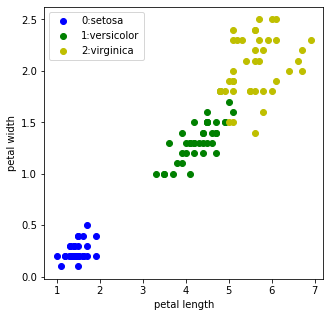

In [2]:
from sklearn.model_selection import train_test_split
data = pd.read_csv("./data/decision_trees/iris_reduced.csv") 
X = data.iloc[:,:2]
y = data.iloc[:,2]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1, test_size=0.2)

plt.figure(figsize=(5,5))
plt.plot(X_train.loc[y_train==0].iloc[:,0], X_train.loc[y_train==0].iloc[:,1], "bo", label="0:setosa" )
plt.plot(X_train.loc[y_train==1].iloc[:,0], X_train.loc[y_train==1].iloc[:,1], "go", label="1:versicolor" )
plt.plot(X_train.loc[y_train==2].iloc[:,0], X_train.loc[y_train==2].iloc[:,1], "yo", label="2:virginica" )
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.legend()
plt.show()

Let's initialize and train a DecisionTree classifier, with `max_depth`=5, and using the Gini index to decrease the impurities at each split. We also initialize the random seed, as scikit-learn randomly permutes the features before training: 

In [3]:
from sklearn.tree import DecisionTreeClassifier
tree_mod = DecisionTreeClassifier(max_depth=5, criterion='gini', random_state=1) 
tree_mod.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

We start by assessing the binary structure (rules) of the tree (in form of text): 

In [4]:
from sklearn.tree import export_text 
tree_rules = export_text(tree_mod, feature_names=list(X_train))
print(tree_rules)

|--- petal_width <= 0.75
|   |--- class: 0
|--- petal_width >  0.75
|   |--- petal_length <= 4.75
|   |   |--- class: 1
|   |--- petal_length >  4.75
|   |   |--- petal_width <= 1.75
|   |   |   |--- petal_length <= 4.95
|   |   |   |   |--- class: 1
|   |   |   |--- petal_length >  4.95
|   |   |   |   |--- petal_width <= 1.55
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- petal_width >  1.55
|   |   |   |   |   |--- class: 1
|   |   |--- petal_width >  1.75
|   |   |   |--- petal_length <= 4.85
|   |   |   |   |--- class: 2
|   |   |   |--- petal_length >  4.85
|   |   |   |   |--- class: 2



Let's now see the values of the first test unit:

In [5]:
X_test.iloc[0]

petal_length    6.3
petal_width     1.8
Name: 107, dtype: float64

According to the tree, such unit should be predicted in Class 2 (the class of Iris Virginica), as it falls exactly in the last leaf at the bottom of the tree. Let's confirm our intuition: 

In [6]:
tree_mod.predict(X_test.iloc[0].to_numpy().reshape(1,-1))

array([2], dtype=int64)

Which is indeed the case. It is also possible to obtain the values of the right and left splits, and of the nodes, as explained in the [documentation](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html). 
We can also obtain a nicer representation of the tree: 

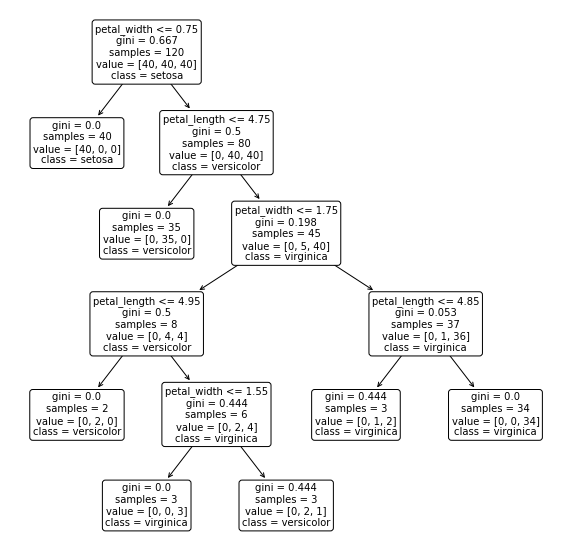

In [7]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10,10))
plot_tree(tree_mod, feature_names=list(X_train), class_names=['setosa', 'versicolor', 'virginica'], filled=False, 
         fontsize=10, rounded=True)
plt.show()

The plot is telling us, for example, that the total Gini index of the dataset (i.e., before starting to split the data) is 0.667, and that the probability of class virginica in the region of the feature space where `petal_width` $\geq 1.75$ and $4.75 <$ `petal_length` $\leq 4.85$ is 2/3 (check this result by yourself). As you can see, by imposing a maximum depth to the tree, some of the leaves of the final tree are not pure. 

Let's check the predicted probabilities for the first five test units: 

In [8]:
tree_mod.predict_proba(X_test[:5])

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

Such units are probably in the interior of the regions, where the estimated tree is more certain about the classification of the units, as all the flowers in the test set are predict with absolute confidence (probability of 1). Let's assess the accuracies of the model in the training and test set:

In [9]:
print("Training Accuracy: {0:.2f}; test accuracy:{1:.2f}".format(tree_mod.score(X_train, y_train), 
                                                                tree_mod.score(X_test, y_test)))

Training Accuracy: 0.98; test accuracy:0.97


This tree does an amazing job in both the training and test set. This is probably due to the fact the the classes can be easily split into axes-aligned regions, which makes decision trees perform greatly. What is the feature that decreases the tree impurity the most? We can assess it with: 

In [10]:
tree_mod.feature_importances_

array([0.42746194, 0.57253806])

This is telling us that `petal_width` contributes to improve about 57% of the overall node impurity, and `petal_length` about 43%. Overall, both features seem to be quite important to determine the splits and the classifications of the *iris* flowers. Let's conclude by plotting the decision regions of the trained tree:  

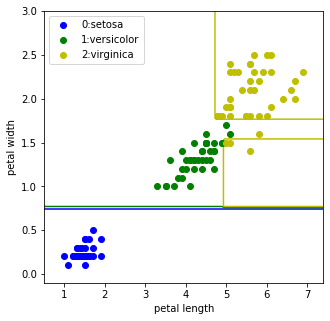

In [11]:
xx1, xx2 = np.meshgrid(np.linspace(X.iloc[:,0].min()-0.5, X.iloc[:,0].max()+0.5, 100),
                       np.linspace(X.iloc[:,1].min()-0.2, X.iloc[:,1].max()+0.5, 100))
zz = tree_mod.predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)


plt.figure(figsize=(5,5))
plt.plot(X_train.loc[y_train==0].iloc[:,0], X_train.loc[y_train==0].iloc[:,1], "bo", label="0:setosa" )
plt.plot(X_train.loc[y_train==1].iloc[:,0], X_train.loc[y_train==1].iloc[:,1], "go", label="1:versicolor" )
plt.plot(X_train.loc[y_train==2].iloc[:,0], X_train.loc[y_train==2].iloc[:,1], "yo", label="2:virginica" )
plt.contour(xx1, xx2, zz, levels=2, colors=['b', 'g', 'y'])
plt.xlabel("petal length")
plt.ylabel("petal width")
plt.legend()
plt.show()

Exercise: Try to play around with the various hyperparameters introduced in section 3 of this notebook, and check how model performance and decision boundaries change. 

### 7.2 Regression Trees 
Also regression trees are in the `scikitlearn.tree` module. They can be called with the function [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor). To ease visualization, we are going to fit a regression tree on a small demo dataset with just one predictor. Of course, the commands used here are the same that you would use with multivariate features. 

In [12]:
data = pd.read_csv("./data/decision_trees/demo_regression.csv")
data.head()

,x,y
0,3.544687,10.563268
1,6.122758,10.800109
2,0.000972,11.038284
3,2.569827,11.623128
4,1.247425,11.987829


In [13]:
data.shape

(110, 2)

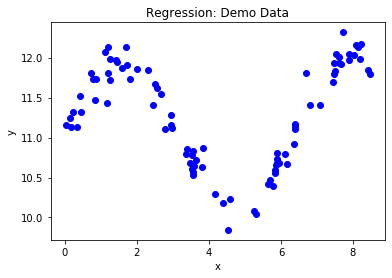

In [14]:
x = data['x']
y = data['y']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

plt.figure(figsize=(6,4))
plt.plot(x_train, y_train, "bo")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regression: Demo Data")
plt.show()

The data seem to be somehow sinusoidal, with some noise around the sine curve. Let's check how a regression tree, trained with maxium depth equal to 10 and MAE loss, performs in this case!

In [15]:
from sklearn.tree import DecisionTreeRegressor
# This step is necessary as we are working with a one-dimensional feature:
x_train_np = x_train.to_numpy().reshape(-1,1)
x_test_np = x_test.to_numpy().reshape(-1,1)

tree_reg_mod = DecisionTreeRegressor(max_depth=5, criterion='mae')
tree_reg_mod.fit(x_train_np, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

The tree structure is: 

In [16]:
from sklearn.tree import export_text 
tree_rules = export_text(tree_reg_mod, feature_names='x')
print(tree_rules)

|--- x <= 7.27
|   |--- x <= 2.72
|   |   |--- x <= 0.59
|   |   |   |--- x <= 0.20
|   |   |   |   |--- x <= 0.15
|   |   |   |   |   |--- value: [11.20]
|   |   |   |   |--- x >  0.15
|   |   |   |   |   |--- value: [11.13]
|   |   |   |--- x >  0.20
|   |   |   |   |--- x <= 0.28
|   |   |   |   |   |--- value: [11.32]
|   |   |   |   |--- x >  0.28
|   |   |   |   |   |--- value: [11.31]
|   |   |--- x >  0.59
|   |   |   |--- x <= 2.37
|   |   |   |   |--- x <= 1.25
|   |   |   |   |   |--- value: [11.73]
|   |   |   |   |--- x >  1.25
|   |   |   |   |   |--- value: [11.91]
|   |   |   |--- x >  2.37
|   |   |   |   |--- x <= 2.47
|   |   |   |   |   |--- value: [11.40]
|   |   |   |   |--- x >  2.47
|   |   |   |   |   |--- value: [11.62]
|   |--- x >  2.72
|   |   |--- x <= 6.27
|   |   |   |--- x <= 3.17
|   |   |   |   |--- x <= 2.86
|   |   |   |   |   |--- value: [11.10]
|   |   |   |   |--- x >  2.86
|   |   |   |   |   |--- value: [11.16]
|   |   |   |--- x >  3.17
|   | 

As you can see, the interpretation can become a little overwhelming with large trees. The tree representation is as follows: 

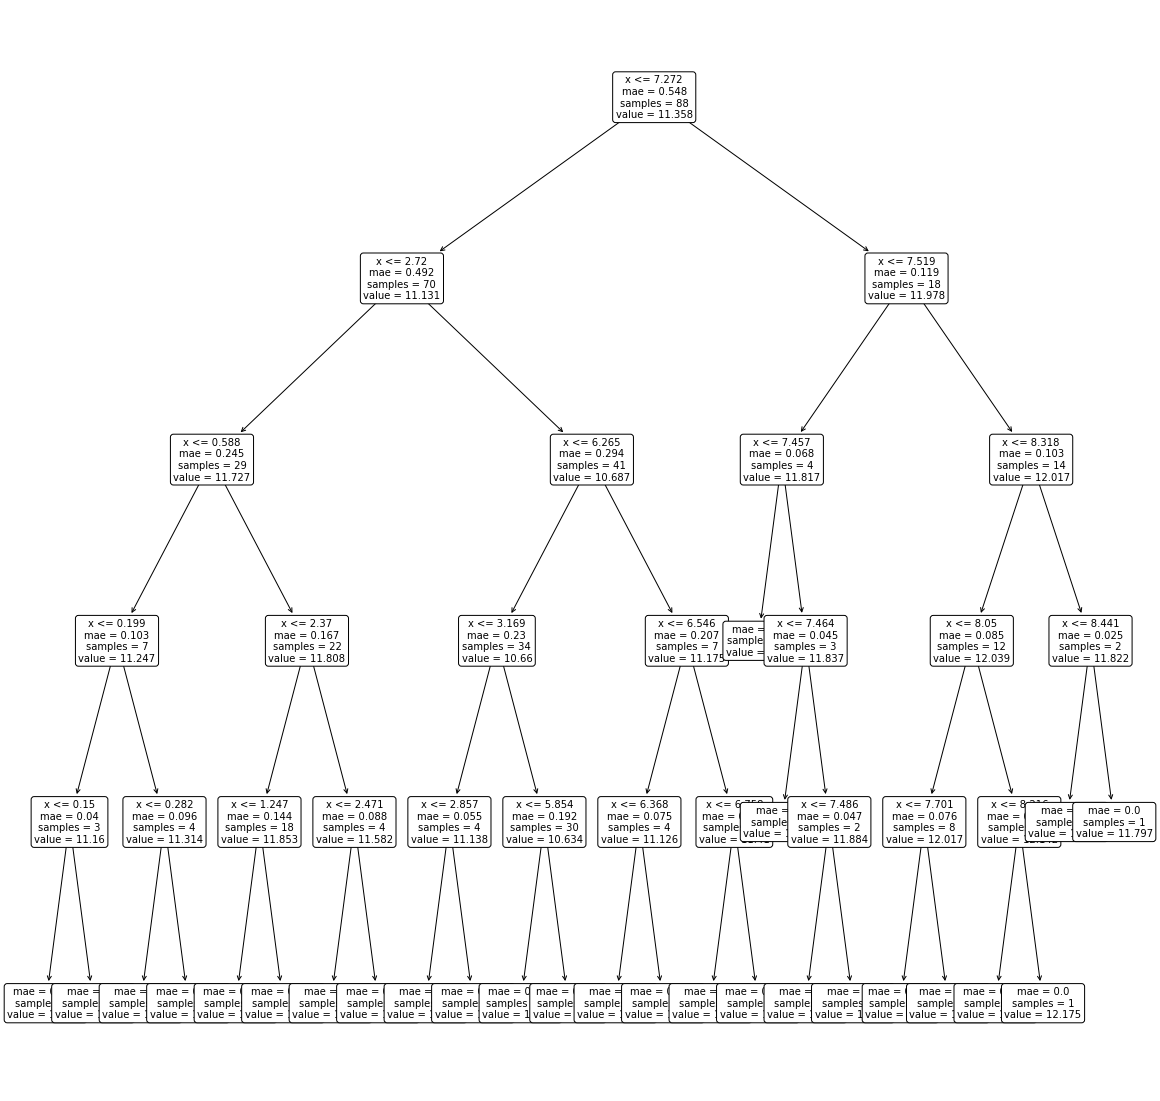

In [17]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,20))
plot_tree(tree_reg_mod, feature_names=list('x'), filled=False, 
         fontsize=10, rounded=True)
plt.show()

The prediction of the first five test data are:

In [18]:
tree_reg_mod.predict(x_test_np[:5])

array([10.56326778, 11.73054064, 10.56326778, 10.56326778, 10.56326778])

The $R^2$ score (default for regression estimators in `scikit-learn`) is: 

In [19]:
tree_reg_mod.score(x_test_np, y_test)

0.725744016136737

This can be interpreted as the percentage of variability in the output of the test data that the predictions given by the tree are able to capture. We are not going to explore feature importances, as in presence of only one feature this will be given 100% importance. We terminate this little demo by confronting the model predictions with the training data: 

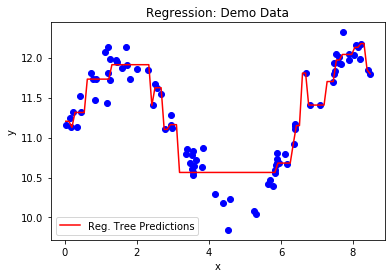

In [20]:
x_range = np.linspace(x_train_np.min(), x_train_np.max(), 100)
reg_pred = tree_reg_mod.predict(x_range.reshape(-1,1))

plt.figure(figsize=(6,4))
plt.plot(x_train, y_train, "bo")
plt.plot(x_range, reg_pred, "r-", label="Reg. Tree Predictions")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Regression: Demo Data")
plt.legend(loc=3)
plt.show()

Exercise: similar to what done for the classification tree, manipulate the hyperparameters of the regression tree to see how it modifies predictions and performance. 

## 8. Example on the Heart Dataset
We are now going to train a decision tree classifier on the Heart Dataset, as done for previous classifiers. This time, we will use the entropy to evaluate the splits at each node; we will, furthermore, tune the hyperparameters `min_samples_split`, which regulates the minimum amount of instances required in a node in order to proceed with the split. (As an exercise, try to repeat the training by tuning a grid of hyperparameters simultaneously: for example, `max_depth`, `min_leaf_nodes`, `min_samples_leaf`, and as many others as you wish). Note also that we are going to work with the already preprocessed dataset, although, for example, scaling the continuous data is not really necessary with decision trees (as already observed in section 6). 

In [21]:
# 1. Load datasets
data_train = pd.read_csv("./data/heart_data/heart_train_processed.csv")
data_test = pd.read_csv("./data/heart_data/heart_test_processed.csv")
X_train = data_train.drop("y", axis=1)
X_test = data_test.drop("y", axis=1)
y_train = data_train["y"]
y_test = data_test["y"]

In [22]:
# Prepare the grid and tune with GridSearchCV
from sklearn.model_selection import GridSearchCV

# Set parameter grid 
min_samples_split_grid = [1, 2, 5, 8, 10, 12, 15, 20, 25, 30, 40, 50]
tuning_parameters = [{'min_samples_split': min_samples_split_grid}]

# Launch GridSearchCV
clf = GridSearchCV(DecisionTreeClassifier(criterion='entropy', random_state=1), tuning_parameters, cv=10, n_jobs=-1, verbose=2 )
clf.fit(X_train, y_train)
print("CV Grid Search: Done")

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CV Grid Search: Done


[Parallel(n_jobs=-1)]: Done 111 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.5s finished


In [23]:
clf.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

The CV accuracy is maximized with 10 minimums samples per node. Let's see how the CV score varies with such hyperparameter:

In [24]:
cv_res = pd.DataFrame(clf.cv_results_).sort_values(by="param_min_samples_split")

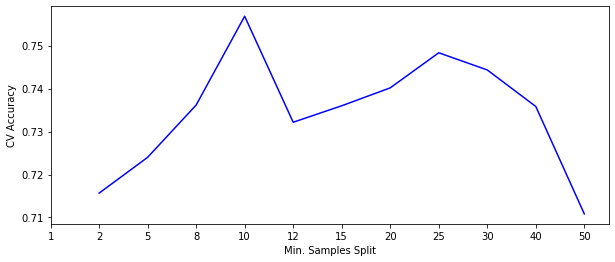

In [31]:
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(1, len(min_samples_split_grid), len(min_samples_split_grid)), 
         cv_res["mean_test_score"], "b-", label="CV Scores")
plt.xlabel("Min. Samples Split")
plt.ylabel("CV Accuracy")
plt.xticks(np.linspace(1, len(min_samples_split_grid), len(min_samples_split_grid)), min_samples_split_grid)
plt.show()

The best CV score is then: 

In [26]:
clf.best_score_

0.7568333333333335

Which is lower than the CV scored observed with linear models and Naive Bayes. Let's now assess the test score:

In [27]:
clf.best_estimator_.score(X_test, y_test)

0.7049180327868853

That is a huge drop with respect to the models encountered so far! Probably the data in the Heart Dataset are not axes-aligned. 

Let's inspect the best decision tree found by cross-validation. It has final depth: 

In [28]:
clf.best_estimator_.get_depth()

8

Visualizing the whole tree can take too much space (you can try to export it with the function [export_graphviz](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html); it requires the graphviz package installed on your local machine). We can, however, ask `plot_tree` to plot only the first two levels of the three by setting `max_depth=2`: 

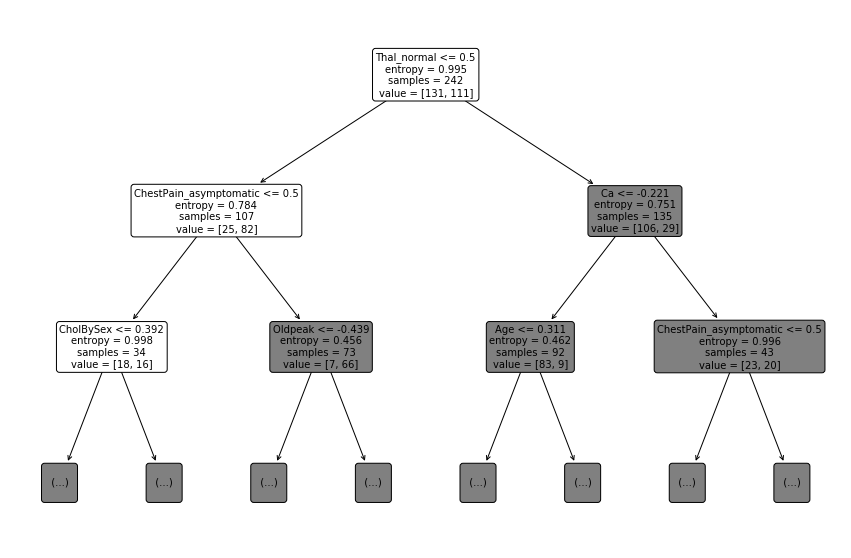

In [29]:
plt.figure(figsize=(15,10))
plot_tree(clf.best_estimator_, feature_names=list(X_train.columns), filled=False, 
         fontsize=10, rounded=True, max_depth=2)
plt.show()

Being at the root node, belonging or not to the `Thal_normal` group seems to be the most discriminant factor detected by the tree. At the second level we find features such as `ChestPain` (`asymptomatic` group) and `Ca`. Let's assess the feature importances of the tree: 

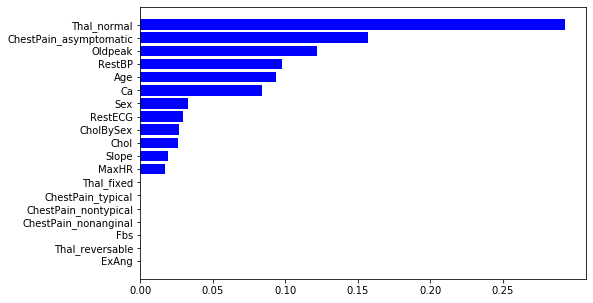

In [30]:
plt.figure(figsize=(8,5))
plt.barh(range(X_train.shape[1]), np.sort(clf.best_estimator_.feature_importances_), color='b')
plt.xticks(np.arange(clf.best_estimator_.feature_importances_.min(), clf.best_estimator_.feature_importances_.max(),0.05))
plt.yticks(range(X_train.shape[1]), X_train.columns[np.argsort(clf.best_estimator_.feature_importances_)])
plt.show()

The most important feature detected by the tree to predict heart disease is the one corresponding to the indicator of the `Thal_normal` category. Other important features include the `ChestPain_asymptomatic`group, `OldPeak`, `RestBP`, and `Age`. How these variable interact with the classes and with other features must be inferred by exploring the tree.  